In [2]:
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
from timm import create_model
import pandas as pd
import numpy as np

In [3]:
import fastai
fastai.__version__

'2.5.3'

In [4]:
import torch
torch.__version__

'1.9.1'

In [5]:
from fastai.vision.all import *

In [6]:
set_seed(999, reproducible=True)
BATCH_SIZE = 8                       #was 32

In [7]:
dataset_path = Path('../input/petfinder-pawpularity-score/')
dataset_path.ls()

(#5) [Path('../input/petfinder-pawpularity-score/sample_submission.csv'),Path('../input/petfinder-pawpularity-score/train.csv'),Path('../input/petfinder-pawpularity-score/test.csv'),Path('../input/petfinder-pawpularity-score/test'),Path('../input/petfinder-pawpularity-score/train')]

In [8]:
train_df = pd.read_csv(dataset_path/'train.csv')
train_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [9]:
train_df['path'] = train_df['Id'].map(lambda x:str(dataset_path/'train'/x)+'.jpg')
train_df = train_df.drop(columns=['Id'])
train_df = train_df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
train_df.head()

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,path
0,0,0,1,1,0,0,0,0,0,0,0,1,50,../input/petfinder-pawpularity-score/train/ebaaa8e384b3d2f0a56c7ff7675c154c.jpg
1,0,1,1,1,0,1,0,1,0,0,1,0,25,../input/petfinder-pawpularity-score/train/25e3bf4267c2dc3f579b779418221bb7.jpg
2,0,0,1,1,0,1,0,0,0,0,0,0,27,../input/petfinder-pawpularity-score/train/6548166fb3fda22b67881176397f0223.jpg
3,0,1,1,1,0,0,0,0,1,1,0,0,19,../input/petfinder-pawpularity-score/train/472c40116e1833555715e4774445ae5b.jpg
4,0,1,1,1,0,0,0,1,0,0,0,0,27,../input/petfinder-pawpularity-score/train/7b77e1a6d93667b575d57db83facd860.jpg


In [12]:
if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
    os.makedirs('/root/.cache/torch/hub/checkpoints/')
!cp '../input/swin-transformer/swin_large_patch4_window7_224_22kto1k.pth' '/root/.cache/torch/hub/checkpoints/swin_large_patch4_window7_224_22kto1k.pth'


In [13]:
seed=999
set_seed(seed, reproducible=True)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

In [18]:
def petfinder_rmse(input,target):
    return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))

In [19]:
def get_data(fold):
    train_df_f = pd.read_csv(f'../input/data-split-pawpularity/skf_split_train_5cv_fold{fold}.csv')
    train_df_f['is_valid'] = False
    valid_df_f = pd.read_csv(f'../input/data-split-pawpularity/skf_split_val_5cv_fold{fold}.csv')
    valid_df_f['is_valid'] = True
    
    train_df_f = train_df_f.append(valid_df_f)
    train_df_f['Id'] = train_df_f['img_path'].apply(lambda x: x.split('.')[-2].split('/')[-1])
    train_df_f['img_path'] = train_df_f['Id'].map(lambda x:str(dataset_path/'train'/x)+'.jpg')
    
    dls = ImageDataLoaders.from_df(train_df_f, #pass in train DataFrame
                               valid_col='is_valid', #
                               seed=999, #seed
                               fn_col='img_path',
                               label_col='Pawpularity',
                               y_block=RegressionBlock, #The type of target
                               bs=BATCH_SIZE, #pass in batch size
                               num_workers=8,
                               item_tfms=Resize(224), #pass in item_tfms
                               batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) #pass in batch_tfms
    return dls


In [20]:
#Valid Kfolder size
the_data = get_data(0)
assert (len(the_data.train) + len(the_data.valid)) == (len(train_df)//BATCH_SIZE)

In [21]:
!ls

__notebook__.ipynb


In [22]:
def get_learner(fold_num):
    data = get_data(fold_num)
    
    model = create_model('swin_large_patch4_window7_224', pretrained=True, num_classes=data.c)

    learn = Learner(data, model, loss_func=BCEWithLogitsLossFlat(), metrics=AccumMetric(func=petfinder_rmse)).to_fp16()
    
    return learn

In [23]:
test_df = pd.read_csv(dataset_path/'test.csv')
test_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0
2,4e429cead1848a298432a0acad014c9d,0,0,0,1,0,1,1,1,0,1,1,1
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0


In [24]:
test_df['Pawpularity'] = [1]*len(test_df)
test_df['path'] = test_df['Id'].map(lambda x:str(dataset_path/'test'/x)+'.jpg')
test_df = test_df.drop(columns=['Id'])
train_df['norm_score'] = train_df['Pawpularity']/100

SuggestedLRs(valley=7.996027125045657e-05)

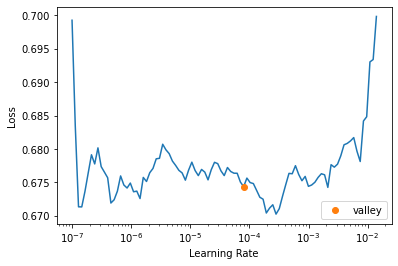

In [25]:
get_learner(fold_num=0).lr_find(end_lr=3e-2)             #was-2

In [26]:
import gc

Fold 0 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.641614,0.647692,18.570923,08:06
1,0.642868,0.643753,18.095228,08:05
2,0.629891,0.641504,17.795574,08:04
3,0.616690,0.645635,18.220360,08:05
4,0.613158,0.646311,18.291687,08:05


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with petfinder_rmse value: 18.5709228515625.
Better model found at epoch 1 with petfinder_rmse value: 18.09522819519043.
Better model found at epoch 2 with petfinder_rmse value: 17.795574188232422.
No improvement since epoch 2: early stopping


Fold 1 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.653374,0.654549,19.372021,08:05
1,0.641815,0.648898,18.674456,08:05
2,0.637613,0.643160,17.933424,08:04
3,0.614960,0.647777,18.418182,08:04
4,0.618477,0.648998,18.523390,08:05


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with petfinder_rmse value: 19.372020721435547.
Better model found at epoch 1 with petfinder_rmse value: 18.674455642700195.
Better model found at epoch 2 with petfinder_rmse value: 17.93342399597168.
No improvement since epoch 2: early stopping


Fold 2 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.647639,0.646220,18.392246,08:04
1,0.641676,0.640551,17.674877,08:05
2,0.630877,0.641109,17.703306,08:06
3,0.619714,0.644157,17.991604,08:06


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with petfinder_rmse value: 18.39224624633789.
Better model found at epoch 1 with petfinder_rmse value: 17.674877166748047.
No improvement since epoch 1: early stopping


Fold 3 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.649800,0.643892,18.060379,08:05
1,0.643905,0.639977,17.534370,08:04
2,0.627191,0.640989,17.579153,08:04
3,0.625261,0.641233,17.612881,08:04


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with petfinder_rmse value: 18.060379028320312.
Better model found at epoch 1 with petfinder_rmse value: 17.53437042236328.
No improvement since epoch 1: early stopping


Fold 4 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.645690,0.645357,18.283289,08:06
1,0.650903,0.648679,18.713345,08:04
2,0.637163,0.641884,17.813353,08:04
3,0.622343,0.641625,17.781044,08:06
4,0.620531,0.643562,17.998331,08:04


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with petfinder_rmse value: 18.283288955688477.
Better model found at epoch 2 with petfinder_rmse value: 17.813352584838867.
Better model found at epoch 3 with petfinder_rmse value: 17.781044006347656.


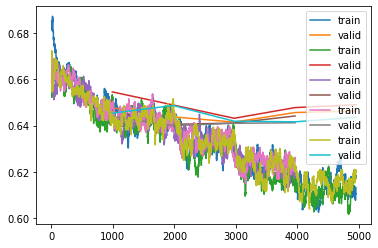

In [28]:
all_preds = []

for i in range(5):

    print(f'Fold {i} results')
    
    learn = get_learner(fold_num=i)

    learn.fit_one_cycle(5, 2e-5, cbs=[SaveModelCallback('petfinder_rmse', comp=np.less), EarlyStoppingCallback(monitor='petfinder_rmse', comp=np.less, patience=2)]) 
    
    learn.recorder.plot_loss()

    learn = learn.to_fp32()
    
    learn.export(f'model_fold_{i}.pkl')
    #learn.save(f'model_fold_{i}.pkl')
    
    dls = ImageDataLoaders.from_df(train_df, #pass in train DataFrame
                               valid_pct=0.2, #80-20 train-validation random split
                               seed=999, #seed
                               fn_col='path', #filename/path is in the second column of the DataFrame
                               label_col='norm_score', #label is in the first column of the DataFrame
                               y_block=RegressionBlock, #The type of target
                               bs=BATCH_SIZE, #pass in batch size
                               num_workers=8,
                               item_tfms=Resize(224), #pass in item_tfms
                               batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) 
    
    test_dl = dls.test_dl(test_df)
    
    preds, _ = learn.tta(dl=test_dl, n=5, beta=0)
    
    all_preds.append(preds)
    
    del learn

    torch.cuda.empty_cache()

    gc.collect()

In [29]:
!ls ..

input  lib  src  working


In [30]:
all_preds

[tensor([[0.4683],
         [0.4699],
         [0.4552],
         [0.4680],
         [0.4815],
         [0.4795],
         [0.4594],
         [0.4697]]),
 tensor([[0.3971],
         [0.4050],
         [0.4040],
         [0.4121],
         [0.3940],
         [0.3986],
         [0.3995],
         [0.4065]]),
 tensor([[0.3714],
         [0.3922],
         [0.3712],
         [0.3851],
         [0.3697],
         [0.3753],
         [0.3755],
         [0.3774]]),
 tensor([[0.4398],
         [0.4466],
         [0.4454],
         [0.4541],
         [0.4345],
         [0.4420],
         [0.4401],
         [0.4499]]),
 tensor([[0.3654],
         [0.3890],
         [0.3767],
         [0.3841],
         [0.3816],
         [0.3847],
         [0.3719],
         [0.3747]])]

In [31]:
sample_df = pd.read_csv(dataset_path/'sample_submission.csv')
preds = np.mean(np.stack(all_preds), axis=0)
sample_df['Pawpularity'] = preds*100
sample_df.to_csv('submission.csv',index=False)

In [32]:
pd.read_csv('submission.csv').head()

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,40.839350
1,43a2262d7738e3d420d453815151079e,42.054695
2,4e429cead1848a298432a0acad014c9d,41.050156
3,80bc3ccafcc51b66303c2c263aa38486,42.070470
4,8f49844c382931444e68dffbe20228f4,41.225933
